In [30]:
import numpy
import astropy.units as u
import rebound
from galpy.orbit import Orbit
from galpy.util import bovy_coords
from galpy.potential import KeplerPotential
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
from galpy.util import bovy_plot
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,
                     xtick_labelsize=15.,ytick_labelsize=15.)
_SAVE_GIFS= False

# The orbit of S2 and its Schwarzschild precession with ``galpy``

[Gravity Collaboration et al. (2020)](https://arxiv.org/pdf/2004.07187.pdf) announced the detection of the Schwarzschild precession of the star S2 that is orbiting the supermassive black hole at the Milky Way's center. Let's see whether we can reproduce its orbit, both with and without taking into account Schwarzschild precession, using ``galpy``

## Getting the initial conditions using ``rebound``

The initial conditions in Gravity Collaboration et al. (2020) are given in terms of orbital elements, so we need to convert these to cartesian coordinates. To do this, we use  ``rebound``. We set up a simulation with the orbital elements given by Gravity Collaboration et al.:

In [31]:
R0= 8246.7*u.pc
vo= 220.*u.km/u.s
MSgrA= 4.261*10**6*u.Msun
sim= rebound.Simulation()
sim.units= ('AU', 'yr', 'Msun')
# GC
sim.add(m=MSgrA.to_value(u.Msun))
# S2
sim.add(m=0.,
        a=(125.058*u.mas*R0).to_value(u.AU,equivalencies=u.dimensionless_angles()),
        e=0.884649,
        inc=(134.567*u.deg).to_value(u.rad),
        omega=(66.263*u.deg).to_value(u.rad),
        Omega=(228.171*u.deg).to_value(u.rad),
        T=(8.37900*u.yr).to_value(u.yr)-0.35653101) # time since 2010's apocenter (calculated: 2010+0.35653101)

Next we convert to cylindrical cartesian coordinates and initialize a ``galpy`` orbit. The cartesian frame used by Gravity Collaboration et al. is that with the $X-Y$ being the plane of the sky and $Z$ being the line-of-sight direction. The $Y$ component corresponds to RA and the $X$ component to Dec (apparently). Thus, we initialize the orbit in ``galpy`` using ``radec=True`` in ``galpy`` and calculate the initial RA,Dec, etc. coordinates using the position of Sgr A* as reference:

In [32]:
ogc= Orbit([0.,0.,0.,0.,0.,0.],ro=R0,vo=vo)

In [33]:
pt= sim.particles[1]
o= Orbit([(ogc.ra()*u.deg+(pt.y*u.AU/R0).to(u.deg,equivalencies=u.dimensionless_angles())).to_value(u.deg),
          (ogc.dec()*u.deg+(pt.x*u.AU/R0).to(u.deg,equivalencies=u.dimensionless_angles())).to_value(u.deg),
          (ogc.dist()*u.kpc+pt.z*u.AU).to_value(u.kpc),
          (ogc.pmra()*(u.mas/u.yr)+(pt.vy*u.AU/u.yr/R0).to(u.mas/u.yr,equivalencies=u.dimensionless_angles())).to_value(u.mas/u.yr),
          (ogc.pmdec()*(u.mas/u.yr)+(pt.vx*u.AU/u.yr/R0).to(u.mas/u.yr,equivalencies=u.dimensionless_angles())).to_value(u.mas/u.yr),
          (ogc.vlos()*(u.km/u.s)+pt.vz*u.AU/u.yr).to_value(u.km/u.s)],
         radec=True,ro=R0,vo=vo)

## Integrate the orbit with ``galpy``

Next, we integrate the orbit and compare to the literature:

In [34]:
times= numpy.linspace(0.,2.*16.0455,100001)*u.yr # 2 periods
kp= KeplerPotential(amp=MSgrA,ro=R0)
o.integrate(times,kp)

The orbit in RA and Dec relative to Sgr A* looks similar to what's in all S2 papers:

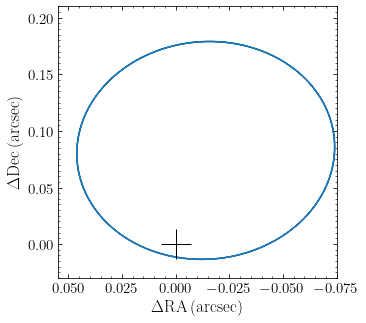

In [36]:
figsize=(5,10)
o.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
      xlabel=r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$',
      ylabel=r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$')
plt.plot([0.],[0.],'k+',ms=30.)
plt.xlim(0.055,-0.075)
plt.ylim(-0.03,0.21);

We can also look at RA, Dec, and $v_{\mathrm{los}}$ as a function of time:

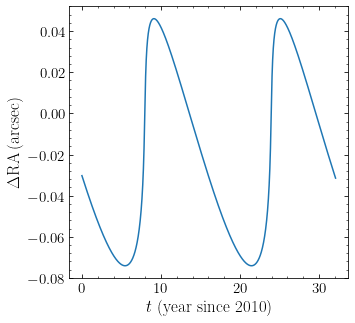

In [38]:
figsize=(8,5)
o.plot(d1='t*1e9',
        d2='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
      xlabel=r'$t\ (\mathrm{year\ since\ 2010})$',
      ylabel=r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$');

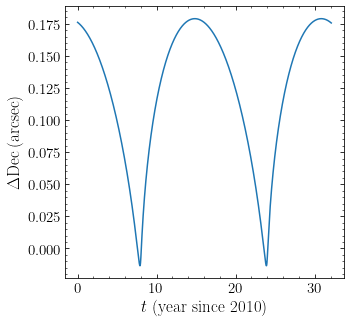

In [39]:
figsize=(8,5)
o.plot(d1='t*1e9',
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
      xlabel=r'$t\ (\mathrm{year\ since\ 2010})$',
      ylabel=r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$');

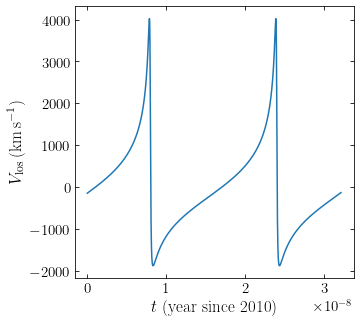

In [41]:
plt.plot(o.time()*(u.yr),o.vlos(times))
plt.xlabel(r'$t\ (\mathrm{year\ since\ 2010})$')
plt.ylabel(r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$');

## Modeling Schwarzschild precession with ``galpy``

To compute the Schwarzschild precession, we implement the approximate GR force as class that inherits from ``DissipativeForce`` in ``galpy``, which can take velocity input. We implement the following form

\begin{equation}
    \vec{a}_{\mathrm{SP}} = f_\mathrm{SP}\,\frac{GM}{c^2r^2}\left[\left(2(\gamma+\beta)\,\frac{GM}{r}-\gamma\,v^2\right)\frac{\vec{r}}{r}+2(1+\gamma)\,v_r\,\vec{v}\right]\,.
\end{equation}

This form includes both the overall 'GR' factor that Gravity Collaboration et al. (2020) use to detect the GR effect as $f_\mathrm{SP} = 1$ and the PPN parameters $\gamma$ and $\beta$, which are useful for checking for example that there is no GR precession when $\beta = 2(1+\gamma)$.

In [42]:
from galpy.potential.DissipativeForce import DissipativeForce
from astropy.constants import c
c= c.to_value(u.km/u.s)
class SchwarzschildPrecessionForce(DissipativeForce):
    def __init__(self,amp=1.,fsp=1.,gamma=1.,beta=1.,ro=None,vo=None):
        DissipativeForce.__init__(self,amp=amp,ro=ro,vo=vo,
                                  amp_units='mass')
        self._fsp= fsp
        self._gamma= gamma
        self._beta= beta
    # Following functions implement the vec{r}/r and \vec{v} parts, respectively
    def _force_firstterm(self,r,v):
        return 1./(c/self._vo)**2./r**3.*(2.*(self._gamma+self._beta)*self._amp/r-self._gamma*v**2.)
    def _force_secondterm(self,r,vr):
        return 2.*(1.+self._gamma)/(c/self._vo)**2./r**2.*vr
    # Now compute the three projections of the forve
    def _Rforce(self,R,z,phi=0.,t=0.,v=None):
        r= numpy.sqrt(R**2.+z**2.)
        vr= R/r*v[0]+z/r*v[2]
        vmag= numpy.sqrt(v[0]**2.+v[1]**2.+v[2]**2.)
        return self._fsp*(self._force_firstterm(r,vmag)*R+self._force_secondterm(r,vr)*v[0])
    def _zforce(self,R,z,phi=0.,t=0.,v=None):
        r= numpy.sqrt(R**2.+z**2.)
        vr= R/r*v[0]+z/r*v[2]
        vmag= numpy.sqrt(v[0]**2.+v[1]**2.+v[2]**2.)
        return self._fsp*(self._force_firstterm(r,vmag)*z+self._force_secondterm(r,vr)*v[2])
    def _phiforce(self,R,z,phi=0.,t=0.,v=None):
        r= numpy.sqrt(R**2.+z**2.)
        vr= R/r*v[0]+z/r*v[2]
        return self._fsp*(self._force_secondterm(r,vr)*v[1]*R)

We can now integrate the orbit of S2 including the effect of Schwarzschild precession. To see the effect clearly, we first multiply the expected for by 5 (``fsp=5``):

In [43]:
sp= SchwarzschildPrecessionForce(amp=MSgrA,ro=R0,fsp=5.)

In [44]:
times= numpy.linspace(0.,4.*16.0455,1001)*u.yr # 4 periods
o.integrate(times,kp)
osp= o()
osp.integrate(times,kp+sp)

The radius is not that affected:

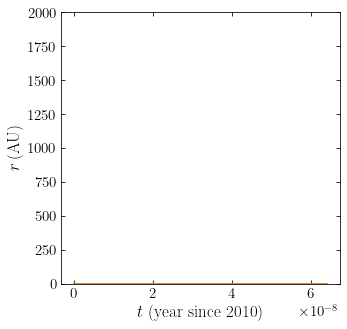

In [45]:
figsize=(8,5)
plt.plot(o.time()*(u.yr),o.r(times)*(u.AU))
plt.plot(osp.time()*(u.yr),osp.r(times)*(u.AU))
plt.xlabel(r'$t\ (\mathrm{year\ since\ 2010})$')
plt.ylabel(r'$r\,(\mathrm{AU})$')
plt.ylim(0.,2000.);

But the orbit in (RA,Dec) is:

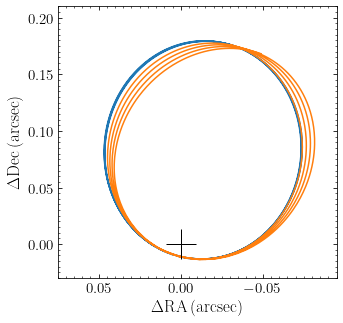

In [47]:
figsize=(5,10)
o.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
      xlabel=r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$',
      ylabel=r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$')
osp.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
        overplot=True)
plt.plot([0.],[0.],'k+',ms=30.)
plt.xlim(0.075,-0.095)
plt.ylim(-0.03,0.21);

Now let's look at the actual expected signature (``fsp=1``):

In [48]:
sp= SchwarzschildPrecessionForce(amp=MSgrA,ro=R0,fsp=1.)

In [49]:
times= numpy.linspace(0.,4.*16.0455,1001)*u.yr # 4 periods
o.integrate(times,kp)
osp= o()
osp.integrate(times,kp+sp)

The precession is now much smaller, but still noticeable:

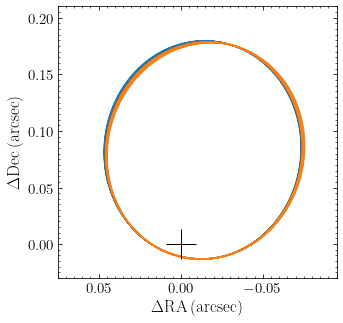

In [50]:
figsize=(5,11)
o.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       xlabel=r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$',
       ylabel=r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$')
osp.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
        overplot=True)
plt.plot([0.],[0.],'k+',ms=30.)
plt.xlim(0.075,-0.095)
plt.ylim(-0.03,0.21);

The signatures in $v_\mathrm{los}$, RA, and Dec are similar to that shown in Gravity Collaboration et al. (2020):

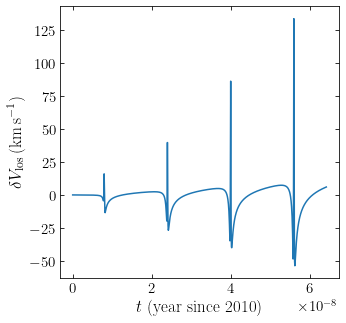

In [52]:
figsize=(8,5)
plt.plot(o.time(),osp.vlos(times)-o.vlos(times)) #Changed the to_year
plt.xlabel(r'$t\ (\mathrm{year\ since\ 2010})$')
plt.ylabel(r'$\delta V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$');

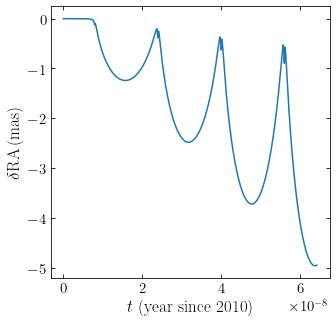

In [53]:
figsize=(8,5)
plt.plot(o.time(),(osp.ra(times)-o.ra(times))
     *(u.deg/u.mas).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles()))
plt.xlabel(r'$t\ (\mathrm{year\ since\ 2010})$')
plt.ylabel(r'$\delta \mathrm{RA}\,(\mathrm{mas})$');

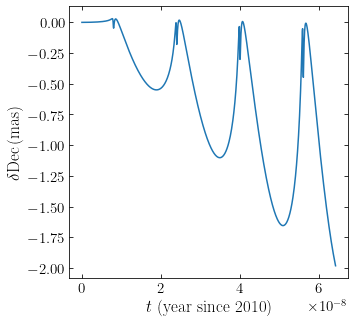

In [55]:
figsize=(8,5)
plt.plot(o.time(),(osp.dec(times)-o.dec(times))
     *(u.deg/u.mas).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles()))
plt.xlabel(r'$t\ (\mathrm{year\ since\ 2010})$')
plt.ylabel(r'$\delta \mathrm{Dec}\,(\mathrm{mas})$');

Finally, let's check that when setting $\beta = 2(1+\gamma) = 4$ for $\gamma=1$ we get zero precession:

In [56]:
spzero= SchwarzschildPrecessionForce(amp=MSgrA,ro=R0,fsp=1.,beta=4.,gamma=1.)

We integrate for 20 orbits to clearly show the difference:

In [57]:
times= numpy.linspace(0.,20.*16.0455,10001)*u.yr # 4 periods
o.integrate(times,kp)
osp= o()
osp.integrate(times,kp+sp)
ospz= o()
ospz.integrate(times,kp+spzero)

In the next figure, blue is the Keplerian orbit, orange the GR orbit, and green the PPN orbit with $\beta = 2(1+\gamma)$:

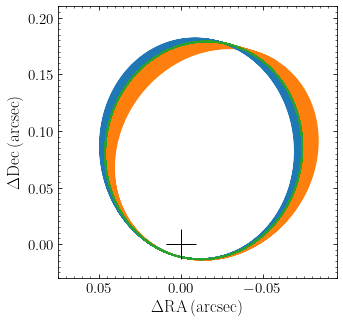

In [58]:
figsize=(5,11)
o.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       xlabel=r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$',
       ylabel=r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$')
osp.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
        overplot=True,zorder=0)
ospz.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
        overplot=True,zorder=2)
plt.plot([0.],[0.],'k+',ms=30.)
plt.xlim(0.075,-0.095)
plt.ylim(-0.03,0.21);

Indeed, the green curve does not have any Schwarzschild precession.

## Animation of the Schwarzschild precession of S2

Next, we make a quick animation of the precession of the orbit of S2. For this, we integrate for a *long time* and then plot successive frames of a single orbit:

In [59]:
nperiods= 600.
times= numpy.linspace(0.,nperiods*16.0455,1000001)*u.yr # 4 periods
o.integrate(times[times < 16.0455*u.yr],kp)
osp= o()
osp.integrate(times,kp+sp)

In [68]:
def delta_ra(ra):
    return (ra-ogc.ra())\
        *(u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())
def delta_dec(dec):
    return (dec-ogc.dec())\
        *(u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())
figsize=(6,7)
fig, ax= plt.subplots()
line1= plt.plot(delta_ra(o.ra(o.time())),delta_dec(o.dec(o.time())),
            label=r'$\mathrm{without\ Schwarzschild\ precession}$')
line2= plt.plot([0.],[0.],'k+',ms=30.)
plt.xlabel(r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$')
plt.ylabel(r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$')
plt.xlim(0.075,-0.25)
plt.ylim(-0.19,0.26)
nstride= round(len(times)/nperiods)+1
line,= ax.plot(delta_ra(osp.ra(times[:nstride])),delta_dec(osp.dec(times[:nstride])),'-',
               label=r'$\mathrm{with\ Schwarzschild\ precession}$')
txt= ax.annotate(r'$\mathrm{year}=%.0f$' % (round(2010.35653101,-1)),
                 (0.05,0.05),xycoords='axes fraction',
                 horizontalalignment='left',verticalalignment='bottom',size=18.)
plt.legend(frameon=False,fontsize=18.,loc='upper right')
def animate(ii):
    minii= int(round((ii+0.5)*nstride))
    maxii= int(round((ii+1.5)*nstride))
    line.set_xdata(delta_ra(osp.ra(times[minii:maxii])))
    line.set_ydata(delta_dec(osp.dec(times[minii:maxii])))
    txt.set_text(r'$\mathrm{year}=%.0f$' % (round(2010.35653101+times[ii*nstride].to_value(u.yr),-1)))
    return (line,)
anim = animation.FuncAnimation(fig,animate,#init_func=init_anim_frame,
                               frames=len(times)//nstride,interval=40,blit=True,repeat=True)
plt.tight_layout()
if _SAVE_GIFS:
    anim.save('gravity-sp.gif',writer='imagemagick',dpi=80)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

RuntimeError: Requested MovieWriter (ffmpeg) not available